Multi-class (non-binary) classification problem. Classify Reuters newswires into mutually exclusive topics.

#### Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from tensorflow import keras

## Data loading

In [27]:
from keras.datasets import reuters
num_words = int(1e4)
(x_train_raw, y_train_raw), (x_valid_raw, y_valid_raw) = reuters.load_data(num_words=num_words)

In [28]:
for i in [x_train_raw, y_train_raw, x_valid_raw, y_valid_raw]:
    print(i.shape)

(8982,)
(8982,)
(2246,)
(2246,)


In [21]:
help(reuters)

Help on module keras.datasets.reuters in keras.datasets:

NAME
    keras.datasets.reuters - Reuters topic classification dataset.

FUNCTIONS
    get_word_index(path='reuters_word_index.json')
        Retrieves a dict mapping words to their index in the Reuters dataset.
        
        Args:
            path: where to cache the data (relative to `~/.keras/dataset`).
        
        Returns:
            The word index dictionary. Keys are word strings, values are their
            index.
    
    load_data(path='reuters.npz', num_words=None, skip_top=0, maxlen=None, test_split=0.2, seed=113, start_char=1, oov_char=2, index_from=3, **kwargs)
        Loads the Reuters newswire classification dataset.
        
        This is a dataset of 11,228 newswires from Reuters, labeled over 46 topics.
        
        This was originally generated by parsing and preprocessing the classic
        Reuters-21578 dataset, but the preprocessing code is no longer packaged
        with Keras. See this
  

In [18]:
import keras.datasets as datasets
help(datasets)

Help on package keras.datasets in keras:

NAME
    keras.datasets - Small NumPy datasets for debugging/testing.

PACKAGE CONTENTS
    boston_housing
    cifar
    cifar10
    cifar100
    fashion_mnist
    imdb
    mnist
    reuters

FILE
    /home/kmc3817/.conda/envs/keras-cpu/lib/python3.7/site-packages/keras/datasets/__init__.py




## Data processing

### Data

In [29]:
def data2tensor(data, num_of_indices):
    """
    data : list
    num_of_indices : int
        Number of indices in the index base, e.g. words in the dictionary
    """
    tensor = np.zeros((len(data), num_of_indices))
    for i, data_point in enumerate(data):
        # data point is actually a LIST of words indicesk
        # we can use this list of indices directly!
        tensor[i, data_point] = 1 # replace 0 with 1 for all the words in the data_point
    return tensor
x_train = data2tensor(x_train_raw, num_words)
x_valid = data2tensor(x_valid_raw, num_words)

### Labels

In [12]:
np.max(y_train_raw), np.max(y_valid_raw)

(45, 45)

In [21]:
num_labels = 46

In [30]:
y_train = data2tensor(y_train_raw, num_labels)
y_valid = data2tensor(y_valid_raw, num_labels)

In [33]:
y_train_raw

array([ 3,  4,  3, ..., 25,  3, 25])

In [32]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model specs

In [17]:
from keras import models
from keras import layers

In [5]:
# help(models.Sequential)

In [62]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(num_words,))) # input only in 1st layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_labels, activation='softmax'))

## Optimisation specs & compilation

Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided in a `one_hot` representation

In [63]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
from keras import losses
help(losses.CategoricalCrossentropy)

Help on class CategoricalCrossentropy in module keras.losses:

class CategoricalCrossentropy(LossFunctionWrapper)
 |  CategoricalCrossentropy(from_logits=False, label_smoothing=0.0, axis=-1, reduction='auto', name='categorical_crossentropy')
 |  
 |  Computes the crossentropy loss between the labels and predictions.
 |  
 |  Use this crossentropy loss function when there are two or more label
 |  classes. We expect labels to be provided in a `one_hot` representation. If
 |  you want to provide labels as integers, please use
 |  `SparseCategoricalCrossentropy` loss.  There should be `# classes` floating
 |  point values per feature.
 |  
 |  In the snippet below, there is `# classes` floating pointing values per
 |  example. The shape of both `y_pred` and `y_true` are
 |  `[batch_size, num_classes]`.
 |  
 |  Standalone usage:
 |  
 |  >>> y_true = [[0, 1, 0], [0, 0, 1]]
 |  >>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
 |  >>> # Using 'auto'/'sum_over_batch_size' reduction type.
 |  

In [13]:
help(metrics)

Help on package keras.metrics in keras:

NAME
    keras.metrics - All Keras metrics.

PACKAGE CONTENTS
    base_metric
    metrics

FUNCTIONS
    deserialize(config, custom_objects=None)
        Deserializes a serialized metric class/function instance.
        
        Args:
          config: Metric configuration.
          custom_objects: Optional dictionary mapping names (strings) to custom
            objects (classes and functions) to be considered during deserialization.
        
        Returns:
            A Keras `Metric` instance or a metric function.
    
    get(identifier)
        Retrieves a Keras metric as a `function`/`Metric` class instance.
        
        The `identifier` may be the string name of a metric function or class.
        
        >>> metric = tf.keras.metrics.get("categorical_crossentropy")
        >>> type(metric)
        <class 'function'>
        >>> metric = tf.keras.metrics.get("CategoricalCrossentropy")
        >>> type(metric)
        <class '...me

# Train on data subset
Validate the method by checking for instance when the model starts to overfit.

In [43]:
x_train.shape, y_train.shape

((8982, 10000), (8982, 46))

In [45]:
num_subset = x_train.shape[0] // 2
num_subset

4491

In [64]:
num_subset = x_train.shape[0] // 2
x_train_train = x_train[:num_subset]
x_train_valid = x_train[num_subset:]

y_train_train = y_train[:num_subset]
y_train_valid = y_train[num_subset:]

In [65]:
out = model.fit(x_train_train, y_train_train, epochs=20, batch_size=512, 
                    validation_data=(x_train_valid, y_train_valid))

Epoch 1/20
9/9 [==============================] - 1s 76ms/step - loss: 3.1009 - accuracy: 0.4387 - val_loss: 2.2594 - val_accuracy: 0.5518
Epoch 2/20
9/9 [==============================] - 0s 40ms/step - loss: 1.9065 - accuracy: 0.6059 - val_loss: 1.6427 - val_accuracy: 0.6900
Epoch 3/20
9/9 [==============================] - 0s 34ms/step - loss: 1.3839 - accuracy: 0.7123 - val_loss: 1.4016 - val_accuracy: 0.7092
Epoch 4/20
9/9 [==============================] - 0s 37ms/step - loss: 1.1034 - accuracy: 0.7753 - val_loss: 1.2691 - val_accuracy: 0.7468
Epoch 5/20
9/9 [==============================] - 0s 31ms/step - loss: 0.9054 - accuracy: 0.8234 - val_loss: 1.1777 - val_accuracy: 0.7593
Epoch 6/20
9/9 [==============================] - 0s 38ms/step - loss: 0.7514 - accuracy: 0.8548 - val_loss: 1.1177 - val_accuracy: 0.7622
Epoch 7/20
9/9 [==============================] - 0s 41ms/step - loss: 0.6212 - accuracy: 0.8764 - val_loss: 1.0621 - val_accuracy: 0.7833
Epoch 8/20
9/9 [===========

In [52]:
out.history

{'loss': [0.6322199702262878,
  0.593145489692688,
  0.5579363107681274,
  0.5220195651054382,
  0.4890443980693817,
  0.4565834105014801,
  0.4277796745300293,
  0.3999912738800049,
  0.37323927879333496,
  0.348895400762558,
  0.3261631727218628,
  0.3051780164241791,
  0.2842637896537781,
  0.2674374580383301,
  0.24995405972003937,
  0.2334899604320526,
  0.21861274540424347,
  0.20493462681770325,
  0.19241026043891907,
  0.1815926879644394],
 'accuracy': [0.8401246666908264,
  0.8534847497940063,
  0.8666221499443054,
  0.8795368671417236,
  0.8879982233047485,
  0.8942329287528992,
  0.9000222682952881,
  0.9098196625709534,
  0.9173903465270996,
  0.9236250519752502,
  0.9291917085647583,
  0.9334223866462708,
  0.9374304413795471,
  0.9394344091415405,
  0.9456691145896912,
  0.9510131478309631,
  0.9559118151664734,
  0.9592518210411072,
  0.9596971869468689,
  0.9632598757743835],
 'val_loss': [1.2090855836868286,
  1.2029653787612915,
  1.1913076639175415,
  1.1889240741729

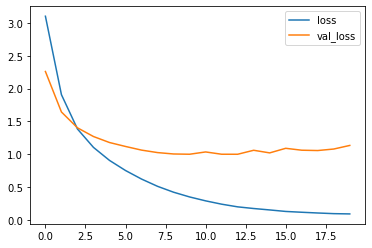

In [67]:
plt.plot(out.history['loss'], label='loss')
plt.plot(out.history['val_loss'], label='val_loss')
plt.legend()

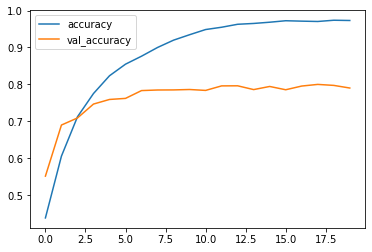

In [68]:
plt.plot(out.history['accuracy'], label='accuracy')
plt.plot(out.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [60]:
out.history

{'loss': [0.6322199702262878,
  0.593145489692688,
  0.5579363107681274,
  0.5220195651054382,
  0.4890443980693817,
  0.4565834105014801,
  0.4277796745300293,
  0.3999912738800049,
  0.37323927879333496,
  0.348895400762558,
  0.3261631727218628,
  0.3051780164241791,
  0.2842637896537781,
  0.2674374580383301,
  0.24995405972003937,
  0.2334899604320526,
  0.21861274540424347,
  0.20493462681770325,
  0.19241026043891907,
  0.1815926879644394],
 'accuracy': [0.8401246666908264,
  0.8534847497940063,
  0.8666221499443054,
  0.8795368671417236,
  0.8879982233047485,
  0.8942329287528992,
  0.9000222682952881,
  0.9098196625709534,
  0.9173903465270996,
  0.9236250519752502,
  0.9291917085647583,
  0.9334223866462708,
  0.9374304413795471,
  0.9394344091415405,
  0.9456691145896912,
  0.9510131478309631,
  0.9559118151664734,
  0.9592518210411072,
  0.9596971869468689,
  0.9632598757743835],
 'val_loss': [1.2090855836868286,
  1.2029653787612915,
  1.1913076639175415,
  1.1889240741729

# Train on full dataset

# Make predictions

# ...